## Benchmark model
Note: this research presents preliminary findings and is being distributed to interested readers solely to stimulate discussion and elicit comments. The benchmark model is used to better understand primary metrics and performance of Azure `AutoML` models and `HyperDrive` tuning options.

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve 
from sklearn.metrics import plot_precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, matthews_corrcoef
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
from IPython.display import Image

## 0. Introduction
The primary objective is to develop an early warning system, i.e. binary classification failed (1) vs. healthy (0), for regulated banks using their quarterly filings with the FDIC. There was a significant increase in the number of failing banks during from 2009 and 2014.

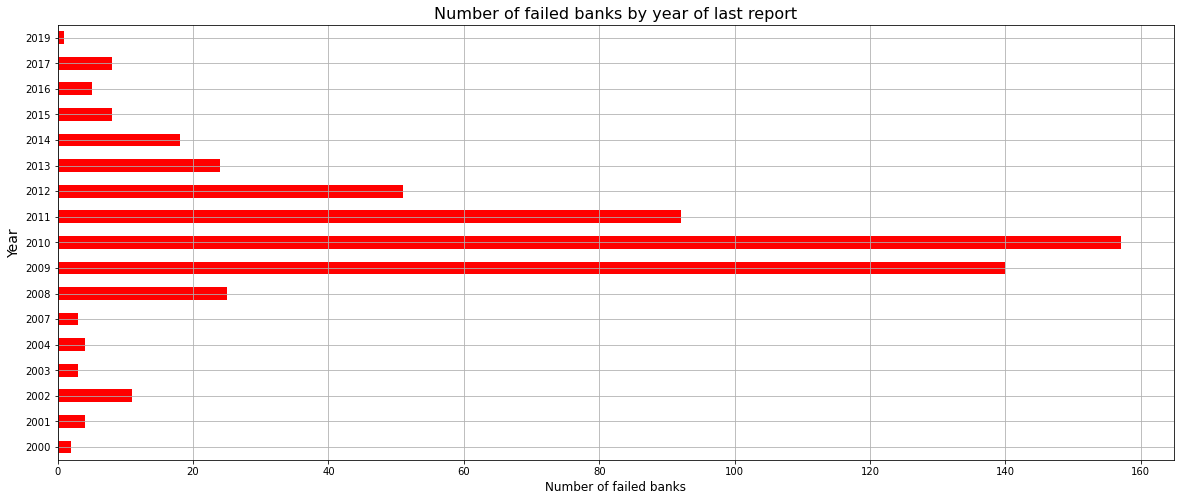

In [370]:
failed_banks = pd.read_csv('data/failed_banks_dataset.csv')
failed_banks['Date'] = pd.to_datetime(failed_banks['Closing Date'])
failed_banks['Year_failed'] = failed_banks['Date'].dt.year
failed_banks['Quarter_failed'] = failed_banks['Date'].dt.quarter
ax = failed_banks.groupby(failed_banks.Date.dt.year)['Bank Name'].count().plot(
    kind='barh', color='r', figsize=(20, 8))
ax.grid()
ax.set_xlabel("Number of failed banks", fontsize=12)
ax.set_ylabel("Year", fontsize=14)
plt.title(label ="Number of failed banks by year of last report", fontsize=16)
plt.show()

Overall, 137 failed banks and 6,877 surviving banks were used for then modeling. Historical data from the first 8 quarters ending 2010Q3 (`./data`) is used to train the model and out-of-sample testing is performed on quarterly data starting from 2012Q4 (`./oos`).  For more information on methodology please view `CAMELS.md` file included in the repository.

#### CALL reports empirical data 
Approximately 2,000 preliminary features were obtained for every bank instance from "Report of Condition and Income" (CALL report) using publicly available SOAP APIs. Eventually, only 14 features were used for classification. For more information please visit https://www.investopedia.com/terms/c/callreport.asp

In [366]:
# Import banks universe surviving after 2010Q3
universe = pd.read_csv('data/reduced_universe_after2010Q3.csv', index_col=0)

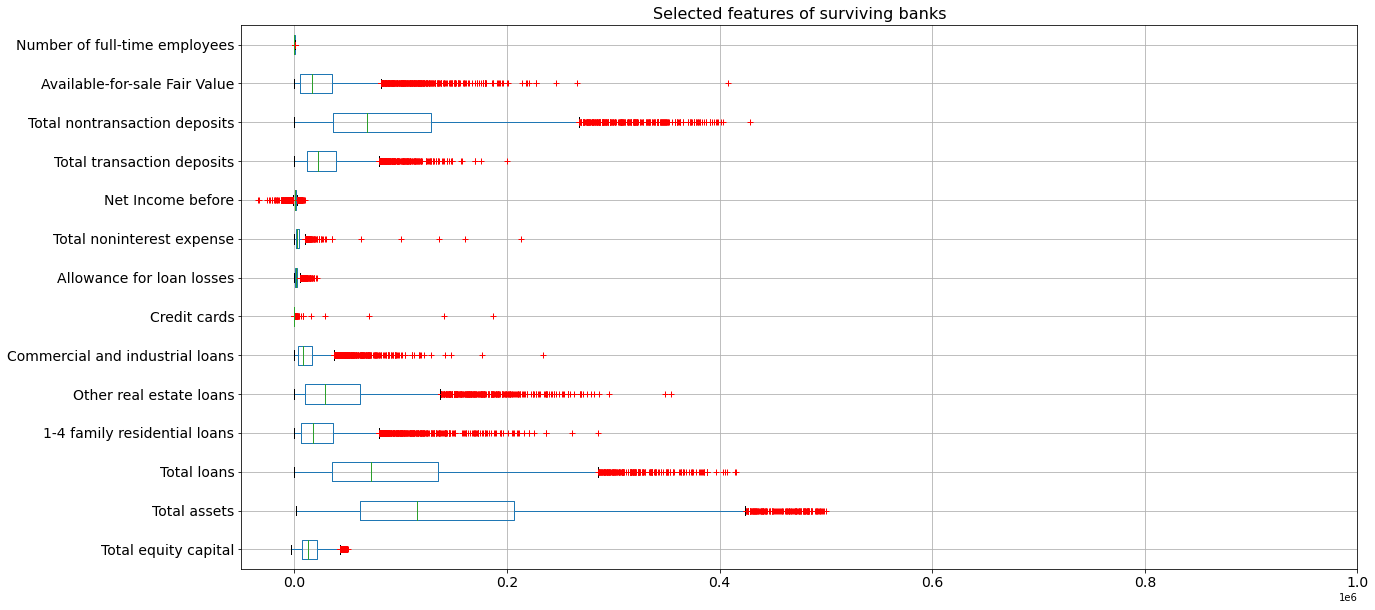

In [367]:
# Features of surving banks
surviving_universe = universe.loc[universe['Target']==0]
surviving_universe.pop('Target')
surviving_universe.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.title(label ="Selected features of surviving banks", fontsize=16)
plt.show()

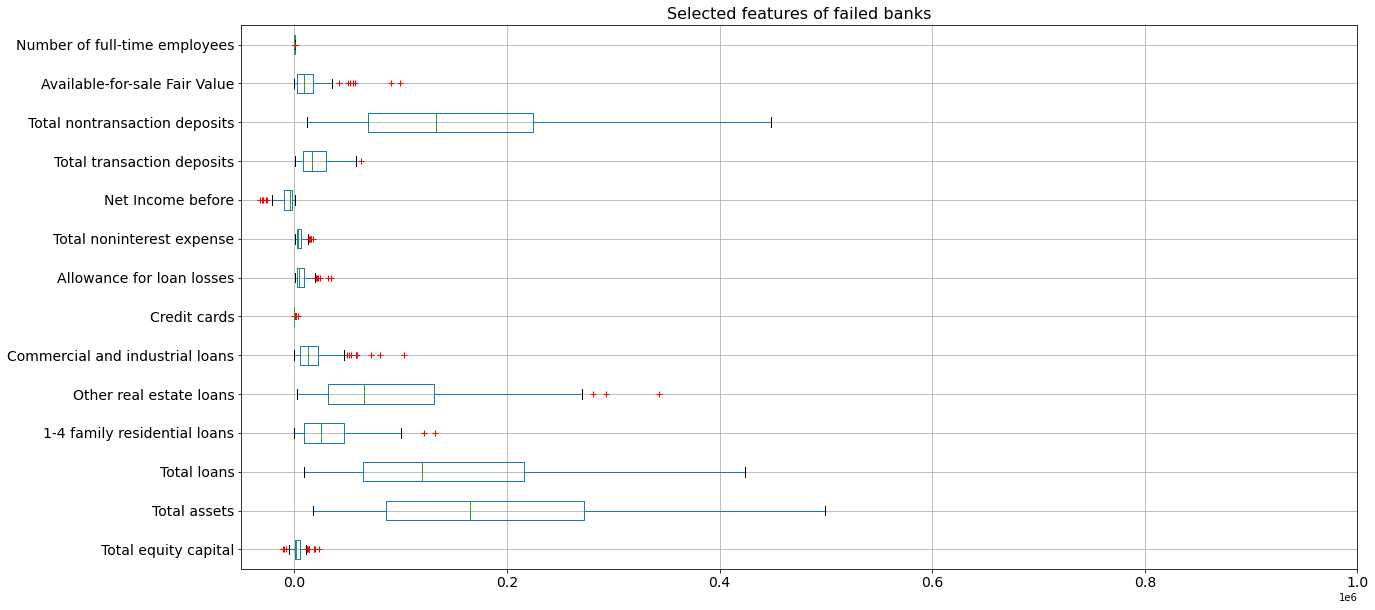

In [368]:
# Features of failed banks
failed_universe = universe.loc[universe['Target']==1]
failed_universe.pop('Target')
failed_universe.boxplot(figsize=(20,10), vert=False, sym='r+', fontsize=14).set_xlim(-50000, 1000000)
plt.title(label ="Selected features of failed banks", fontsize=16)
plt.show()

#### CAMELS featurization 
Selected financial ratios listed above were used to produce unique risk profiles according to CAMELS valuation framework. This framework is used to assess performance along 6 risk dimensions, namely Capital, Assets, Management, Earnings, Liquidity, and Sensitivity to market risk, hence the abbreviation. For more information please visit https://en.wikipedia.org/wiki/CAMELS_rating_system
1. Capital adequace will be measure by 
        - 'EQTA' = Total Equity / Total Assets
        - 'EQTL' = Total Equity / Total Loans
2. Asset quality will be measure by 
        - 'NPLTA' = Non Performing Loans / Total Assets
        - 'NPLGL' = Non Performing Loans / Gross Loans
        - 'LLRTA' = Loan Loss Reserves / Total Assets
        - 'LLRGL' = Loan Loss Reserves / Gross Loans
3. Management quality will be measure by 
        - 'OCNOI' = Operating Costs / Net Operating Income
        - 'OEXTA' = Operating Expenses / Assets
4. Earnings ability will be measure by 
        - 'ROA' = Net Income / Total Assets
        - 'ROE' = Net Income / Total Equity
5. Liquidity, ability to fulfill its short-term liability, will be measure by 
        - 'TLTD' = Total Loans / Total Customer Deposits
        - 'TDTA' = Total Customer Deposits / Total Assets
6. Sensitivity to market risk will be measure by 
        - 'TINOI = Trading Income / Net Operating Income

## 1. Preprocessing

In [250]:
file_path = "data/camel_data_after2010Q3.csv"
banks_df = pd.read_csv(file_path, index_col=0)

Check if there are any missing values and drop `null`

In [251]:
banks_df.dropna(inplace=True)

Show the features of failed banks (Target of 1) and count them

In [252]:
banks_df.loc[banks_df.Target == 1].count()

AsOfDate    137
Target      137
EQTA        137
EQTL        137
LLRTA       137
LLRGL       137
OEXTA       137
INCEMP      137
ROA         137
ROE         137
TDTL        137
TDTA        137
TATA        137
dtype: int64

Take a copy of predictors and store in X, count all instances available.

In [253]:
X = banks_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 'TDTL', 'TDTA', 'TATA']].copy()
len(X)

7014

Define the target vector y and reshape it as well.

In [254]:
y = banks_df["Target"].values.reshape(-1, 1)

## 2. Developing basic Gradient Boosting Classifier 

First train/test split, note `random_state=123` for the auditing purposes.

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

Creating `StandardScaler` object and fitting, i.e. removing the mean and scaling to unit variance.

In [256]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

Transforming training and testing features data using the fitted scaler.

In [257]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## 3. Optimizing Sensitivity (Minimizing Type II Error) with `GridSearch`

In [118]:
param_grid = {'learning_rate': [0.05, 0.1, 0.2, 0.5, 0.7, 0.8, 0.9], 
             "n_estimators" : [20, 30, 40, 50],
              "max_features": [2, 3, 4, 5],
              "max_depth" : [2, 3, 4, 5]} 

grid = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = 'recall', cv=5)
grid.fit(X, y.ravel());
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}

Take note of these parameters listed below:

    `{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 5, 'n_estimators': 20}`

Take note of four evaluation metrics:
- Accuracy: (TP + TN)/(TP + TN + FP + FN)
- Misclassification Rate: 1 - Accuracy or (FP + FN)/(TP + TN + FP + FN)
- Sensitivity (Recall or True Positive Rate): TP / (TP + FN)
- Specificity: TN / (TN + FN)
- False Positive Rate: FP / (TN + FP)
- Precision: TP / (TP + FP)

## 4. Evaluating the best model

In [258]:
clf_best = GradientBoostingClassifier(verbose=3, 
                                      n_estimators=20,
                                      learning_rate=0.1,
                                      max_features=5,
                                      max_depth=2,
                                      random_state=123)

clf_best.fit(X_train_scaled, y_train.ravel())
predictions = clf_best.predict(X_test_scaled)
print("Testing accuracy: {0:.3f}%".format(accuracy_score(predictions, y_test) * 100 ))

      Iter       Train Loss   Remaining Time 
         1           0.1007            0.11s
         2           0.0936            0.11s
         3           0.0844            0.12s
         4           0.0808            0.13s
         5           0.0770            0.12s
         6           0.0736            0.11s
         7           0.0694            0.10s
         8           0.0661            0.08s
         9           0.0621            0.08s
        10           0.0595            0.07s
        11           0.0570            0.06s
        12           0.0547            0.05s
        13           0.0534            0.05s
        14           0.0511            0.04s
        15           0.0493            0.03s
        16           0.0478            0.03s
        17           0.0462            0.02s
        18           0.0453            0.01s
        19           0.0440            0.01s
        20           0.0425            0.00s
Testing accuracy: 98.812%


#### Feature importances
GBM produces feature importances naturally at every split and retraining. One can plot this metric for every feature column from the original CAMELS dataset

In [291]:
importances = clf_best.feature_importances_
feature_list = list(X.columns)
class_names = list(y)
title = "failed banks with basic GBM"

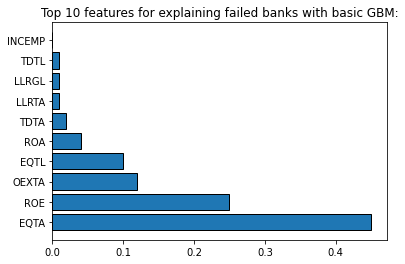

In [292]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
   
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]

plt.barh(x_val, y_val, edgecolor='black')
plt.title('Top 10 features for explaining {}:'.format(title))
plt.show()

#### Visual representation of one GBM pass

In [300]:
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=1234)
clf_tree.fit(X_train_scaled, y_train)


DecisionTreeClassifier(random_state=1234)

In [278]:
from sklearn import tree
text_representation = tree.export_text(clf_tree)
print(text_representation)

|--- feature_1 <= 0.04
|   |--- feature_4 <= 0.02
|   |   |--- feature_10 <= 0.00
|   |   |   |--- feature_0 <= 0.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  0.00
|   |   |   |   |--- class: 0
|   |   |--- feature_10 >  0.00
|   |   |   |--- class: 1
|   |--- feature_4 >  0.02
|   |   |--- feature_6 <= -0.04
|   |   |   |--- feature_4 <= 0.04
|   |   |   |   |--- feature_8 <= 1.18
|   |   |   |   |   |--- feature_5 <= -437.32
|   |   |   |   |   |   |--- feature_4 <= 0.02
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_4 >  0.02
|   |   |   |   |   |   |   |--- feature_9 <= 0.84
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_9 >  0.84
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_5 >  -437.32
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_8 >  1.18
|   |   |   |   |   |--- feature_8 <= 1.24
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |

In [299]:
# with open("decistion_tree.log", "w") as fout:
#     fout.write(text_representation)

#### Class imbalances 
Check for Null Accuracy, i.e. always predicting majority class. Start with class distribution below:

In [209]:
y_true = pd.DataFrame(y_test, columns=['y_true'])
y_true["y_true"].value_counts()

0    1725
1      29
Name: y_true, dtype: int64

In [210]:
print('Calculate the percentage of ones: {0:.3f}%'.format(y_true["y_true"].mean() * 100))

Calculate the percentage of ones: 1.653%


In [135]:
print('Calculate Null accuracy for binary classification: {0:.3f}%'.format(
    max(y_true["y_true"].mean(), 1 - y_true["y_true"].mean()) *100))

Calculate Null accuracy for binary classification: 98.347%


#### Model Performance over Thresholds
The precision-recall curve plots the relationship between precision and recall as the decision threshold changes. Recall is the ability of a model to detect all positive samples and precision is the ability of a model to avoid labeling negative samples as positive. Some business problems might require higher recall and some higher precision depending on the relative importance of avoiding false negatives vs false positives. 

Source: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#precision-recall-curve

2-class Precision-Recall curve: Avg. Precision=0.66


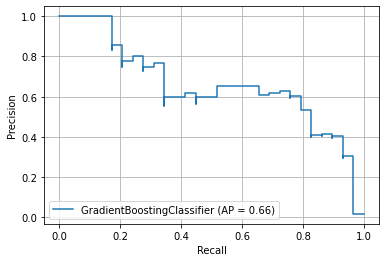

In [218]:
y_score = clf_best.decision_function(X_test_scaled)
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(clf_best, X_test_scaled, y_test)
print('2-class Precision-Recall curve: Avg. Precision={0:0.2f}'.format(average_precision))
plt.grid(True)

The receiver operating characteristic (ROC) curve plots the relationship between true positive rate (TPR) and false positive rate (FPR) as the decision threshold changes. The area under the curve (AUC) can be interpreted as the proportion of correctly classified samples. More precisely, the AUC is the probability that the classifier ranks a randomly chosen positive sample higher than a randomly chosen negative sample. The shape of the curve gives an intuition for relationship between TPR and FPR as a function of the classification threshold or decision boundary. 

Source: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#roc-curve

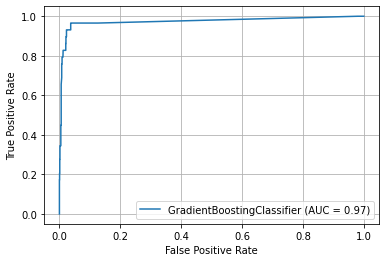

In [217]:
from sklearn.metrics import plot_roc_curve
clf_best_disp = plot_roc_curve(clf_best, X_test_scaled, y_test)
clf_best_disp.plot(ax=ax, alpha=0.8)
plt.grid(True)
plt.show()

#### Generate confusion matrix

In [138]:
pd.DataFrame(confusion_matrix(y_test, predictions), index=["True 0", "True 1"], 
             columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
True 0,1712,13
True 1,9,20


In [219]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
tn, fp, fn, tp

(1712, 13, 9, 20)

In [220]:
print("recall: {0:.2f}".format(tp/(tp+fn)))
print("precision: {0:.2f}".format(tp/(tp+fp))) #TP / (TP + FP)

recall: 0.69
precision: 0.61


#### Compute Matthews correlation

In [145]:
matthews_corrcoef(y_test, predictions)
print("Matthews Correlation is {0:.3f}".format(matthews_corrcoef(y_test, predictions)))

Matthews Correlation is 0.640


#### Generate classification report

In [146]:
print("In-Sample Classification Report")
print(classification_report(y_test, predictions))

In-Sample Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1725
           1       0.61      0.69      0.65        29

    accuracy                           0.99      1754
   macro avg       0.80      0.84      0.82      1754
weighted avg       0.99      0.99      0.99      1754



## 5. Analysing rules that were learned in training

#### Extracting rules and feature importances 

In [115]:
n_classes, n_estimators = clf_best.estimators_.shape

for c in range(n_classes):
    
    for t in range(n_estimators):
        
        dtree = clf_best.estimators_[c, t]
        rules_df = pd.DataFrame({
            'child_left': dtree.tree_.children_left,
            'child_right': dtree.tree_.children_right,
            'feature': dtree.tree_.feature,
            'threshold': dtree.tree_.threshold,
        })
rules_df.head()

,child_left,child_right,feature,threshold
0,1,8,1,-0.023284
1,2,5,6,-2.327335
2,3,4,9,1.581137
3,-1,-1,-2,-2.000000
4,-1,-1,-2,-2.000000


In [317]:
clf_best.predict_proba([[0.3, 1.2, 0.3, 0.2, 0.4, 0, 2, 0, 0, 0, 0 ]])

array([[0.995921, 0.004079]])

In [316]:
clf_best.classes_

array([0, 1])

## 6. Out-of-sample GBM testing 

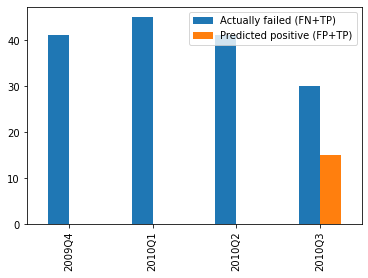

In [330]:
insample = {'2009Q4' : {'Actually failed (FN+TP)' : 41, 'Predicted positive (FP+TP)' : 0}, 
            '2010Q1' : {'Actually failed (FN+TP)' : 45, 'Predicted positive (FP+TP)' : 0},
            '2010Q2' : {'Actually failed (FN+TP)' : 41, 'Predicted positive (FP+TP)' : 0}, 
            '2010Q3' : {'Actually failed (FN+TP)' : 30, 'Predicted positive (FP+TP)' : 15}
           }

results = pd.DataFrame.from_dict(insample, orient='index')
results[['Actually failed (FN+TP)', 'Predicted positive (FP+TP)']].plot(kind='bar')

In [221]:
pd.set_option('use_inf_as_na', True)




oos_reports = ['2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2', 
               '2012Q3', '2012Q4', '2019Q2']

for report in oos_reports:
    
    oos_df = pd.read_csv('oos/camel_data_after{}_OOS.csv'.format(report))
    oos_df.replace([np.inf, -np.inf], np.nan)
    oos_df.dropna(inplace=True)
    
    y_oos = oos_df['Target']
    X_oos = oos_df[['EQTA', 'EQTL', 'LLRTA', 'LLRGL', 'OEXTA', 'INCEMP', 'ROA', 'ROE', 
                    'TDTL', 'TDTA', 'TATA']].copy()
    X_oos_scaled = X_scaler.transform(X_oos) 
    
    predictions_oos = clf_best.predict(X_oos_scaled)
    tn, fp, fn, tp = confusion_matrix(y_oos, predictions_oos).ravel()
    mcc = np.round(matthews_corrcoef(y_oos, predictions_oos), 2)
    
    # Generate out-of-sample MCC and classification report 
    print("*" * 55, "\nMatthews Correlation (MCC) for {} is {}".format(report, mcc))
    print("*" * 55,"\nOut-of-sample (OOS) Classification Report for {}:".format(report))
    print(classification_report(y_oos, predictions_oos), "\n\n")
   
  

******************************************************* 
Matthews Correlation (MCC) for 2010Q4 is 0.66
******************************************************* 
Out-of-sample (OOS) Classification Report for 2010Q4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6779
           1       0.53      0.83      0.65        24

    accuracy                           1.00      6803
   macro avg       0.76      0.92      0.82      6803
weighted avg       1.00      1.00      1.00      6803
 


******************************************************* 
Matthews Correlation (MCC) for 2011Q1 is 0.49
******************************************************* 
Out-of-sample (OOS) Classification Report for 2011Q1:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6713
           1       0.24      1.00      0.38        19

    accuracy                           0.99      6732
   macro avg       0.62 

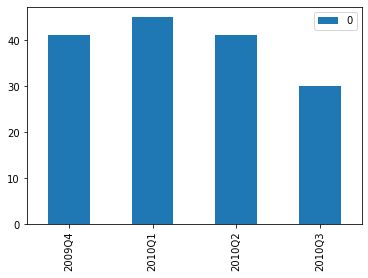

In [324]:
insample = {'2009Q4' : 41, '2010Q1' : 45, '2010Q2': 41, '2010Q3' :30}
df = pd.DataFrame.from_dict(insample, orient='index')
df.plot(kind='bar')